In [1]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from pymatgen.analysis import magnetism
import tqdm
from mat2vec.processing import MaterialsTextProcessor
import tqdm

In [2]:
Elements = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 
    'S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
    'Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
    'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce',
    'Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf',
    'Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
    'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm',
    'Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Uut',
    'Fl','Uup','Lv','Uus','Uuo']



'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [3]:
MPj = pd.read_excel('mats_from_MPj.xlsx', index_col = 0)
MPj = MPj.rename(columns={"pretty_formula": "Components"})
MPj = MPj.dropna()

normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(MPj))):
    MPj['Components'].iloc[i] = normalizer.normalized_formula(MPj['Components'].iloc[i])

  0%|                                                                                       | 0/154715 [00:00<?, ?it/s]C:\Users\giovanni\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|█████████████████████████████████████████████████████████████████████████| 154715/154715 [06:23<00:00, 403.89it/s]


In [5]:
data = pd.read_csv('all_curves.csv') # from here https://figshare.com/articles/dataset/20231101_starrydata2/24467887

data = data[data['prop_y'] == 'Seebeck coefficient']
data = pd.DataFrame(data['composition'].drop_duplicates(keep = 'first'))
for i in tqdm.tqdm(range(len(data))):
    if data.iloc[i]['composition'] == ' ':
        data.iloc[i]['composition'] = np.NaN
    if data.iloc[i]['composition'] == '  ':
        data.iloc[i]['composition'] = np.NaN
    if data.iloc[i]['composition'] == '   ':
        data.iloc[i]['composition'] = np.NaN
    if data.iloc[i]['composition'] == ' \u3000':
        data.iloc[i]['composition'] = np.NaN
    if data.iloc[i]['composition'] == '\u3000':
        data.iloc[i]['composition'] = np.NaN
    if data.iloc[i]['composition'] == '\u3000\u3000':
        data.iloc[i]['composition'] = np.NaN
    if data.iloc[i]['composition'] == '\u3000\u3000\u3000\u3000':
        data.iloc[i]['composition'] = np.NaN
    if data.iloc[i]['composition'] == 'Li0':
        data.iloc[i]['composition'] = np.NaN    
    if data.iloc[i]['composition'] == 'Al0':
        data.iloc[i]['composition'] = np.NaN 
    if data.iloc[i]['composition'] == 'Bi0':
        data.iloc[i]['composition'] = np.NaN         
        
data = data.dropna()

100%|██████████████████████████████████████████████████████████████████████████| 20472/20472 [00:10<00:00, 2023.10it/s]


In [6]:
normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(data))):
    data['composition'].iloc[i] = normalizer.normalized_formula(data['composition'].iloc[i])

100%|██████████████████████████████████████████████████████████████████████████| 20470/20470 [00:05<00:00, 3485.22it/s]


In [7]:
data = data.rename(columns = {'composition': 'Components'})

In [8]:
MPj = MPj[['Components']].drop_duplicates()

In [9]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):
    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, f_classif, chi2, VarianceThreshold
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition

Complete_MPj = featurizing(MPj)

C:\Users\giovanni\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


MultipleFeaturizer:   0%|          | 0/105582 [00:00<?, ?it/s]

In [11]:
Complete_MPj = Complete_MPj.dropna()

In [12]:
data = data.drop_duplicates()

In [13]:
Complete_MPj = Complete_MPj.reset_index()
Complete_MPj['is_in_starrydata'] = 0
for i in tqdm.tqdm(range(len(Complete_MPj))):
    if Complete_MPj['Components'].iloc[i] in list(data['Components']):
        Complete_MPj['is_in_starrydata'].iloc[i] = 1

100%|█████████████████████████████████████████████████████████████████████████| 105578/105578 [03:32<00:00, 497.17it/s]


In [14]:
sum(Complete_MPj['is_in_starrydata'])

1398

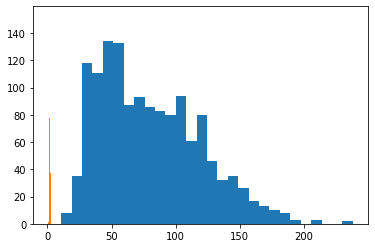

In [15]:
import matplotlib.pyplot as plt
import random
Complete_MPj_no_SuperCon = Complete_MPj[Complete_MPj['is_in_starrydata'] == 0]
c = plt.hist(Complete_MPj[Complete_MPj['is_in_starrydata'] == 1]['MagpieData mean AtomicWeight'].values, bins = 28)
d = plt.hist(Complete_MPj[Complete_MPj['is_in_starrydata'] == 1]['MagpieData mean Electronegativity'].values, bins = 28)
samples_atomic = []
samples_electronegativity = []


for i in range(len(c[1])-1):
    samples_atomic.append(random.sample(set(Complete_MPj_no_SuperCon[Complete_MPj_no_SuperCon['MagpieData mean AtomicWeight'].between(c[1][i], c[1][i+1]) == True].index), 
                  int(c[0][i])))
for i in range(len(d[1])-1):
    samples_electronegativity.append(random.sample(set(Complete_MPj_no_SuperCon[Complete_MPj_no_SuperCon['MagpieData mean Electronegativity'].between(d[1][i], d[1][i+1]) == True].index), 
                  int(d[0][i])))
samples_random = random.sample(set(Complete_MPj_no_SuperCon.index), len(Complete_MPj[Complete_MPj['is_in_starrydata'] == 1]))

    
idxs_iid_atomic = [item for sublist in samples_atomic for item in sublist]
idxs_iid_electronegativity = [item for sublist in samples_electronegativity for item in sublist]
idxs_random = samples_random

Complete_MPj_iid_atomic = pd.concat([Complete_MPj[Complete_MPj['is_in_starrydata'] == 1][['Components', 'is_in_starrydata']], 
           Complete_MPj_no_SuperCon[['Components', 'is_in_starrydata']].loc[idxs_iid_atomic]]).reset_index()[['Components', 'is_in_starrydata']]
Complete_MPj_iid_electronegativity = pd.concat([Complete_MPj[Complete_MPj['is_in_starrydata'] == 1][['Components', 'is_in_starrydata']],
           Complete_MPj_no_SuperCon[['Components', 'is_in_starrydata']].loc[idxs_iid_electronegativity]]).reset_index()[['Components', 'is_in_starrydata']]
Complete_MPj_random = pd.concat([Complete_MPj[Complete_MPj['is_in_starrydata'] == 1][['Components', 'is_in_starrydata']], 
           Complete_MPj_no_SuperCon[['Components', 'is_in_starrydata']].loc[idxs_random]]).reset_index()[['Components', 'is_in_starrydata']]

In [16]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):
    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

In [17]:
df_1 = featurizing(Complete_MPj_iid_atomic)
df_1['is_in_starrydata'] = Complete_MPj_iid_atomic.set_index('Components')['is_in_starrydata']

df_2 = featurizing(Complete_MPj_iid_electronegativity)
df_2['is_in_starrydata'] = Complete_MPj_iid_electronegativity.set_index('Components')['is_in_starrydata']

df_3 = featurizing(Complete_MPj_random)
df_3['is_in_starrydata'] = Complete_MPj_random.set_index('Components')['is_in_starrydata']

df_4 = featurizing(Complete_MPj_random)
df_4['is_in_starrydata'] = 0
for i in range(len(df_4)):
    df_4['is_in_starrydata'].iloc[i] = np.round(random.random())
#len(df.dropna()) - len(df)

MultipleFeaturizer:   0%|          | 0/2796 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/2796 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/2796 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/2796 [00:00<?, ?it/s]

In [18]:
df_1 = df_1.dropna()
df_2 = df_2.dropna()
df_3 = df_3.dropna()
df_4 = df_4.dropna()

train_df_1, test_df_1 = train_test_split(df_1, test_size = 0.2, random_state = 0)
train_df_2, test_df_2 = train_test_split(df_2, test_size = 0.2, random_state = 0)
train_df_3, test_df_3 = train_test_split(df_3, test_size = 0.2, random_state = 0)
train_df_4, test_df_4 = train_test_split(df_4, test_size = 0.2, random_state = 0)

In [19]:
def create_model(train_df):
    
    '''Pipeline for ETC-vanilla'''
    etc = ExtraTreesClassifier(random_state = 0)
    pipe = Pipeline([
        ('decorrelation', MyDecorrelator(0.9)), 
        ('threshold', VarianceThreshold(threshold = 0)), 
        ('feature_selector', SelectPercentile(f_classif)), 
        ('etc', etc)
    ], verbose = 1)
    param_grid = {
        "etc__n_estimators": [100, 250, 500],    #Tune the number of estimators
        "etc__max_features": [1, 0.75, 0.5],  #Tune the number of features to consider when looking for the best split
        "feature_selector__percentile": [50, 75, 100]       #Tune the percentage of features to retain in terms of f_regression score
    }

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0)
    search = GridSearchCV(pipe, param_grid, n_jobs=1, verbose = 1, cv = stratified_kfold)
    search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

    return search

In [20]:
model_1 = create_model(train_df_1)
model_2 = create_model(train_df_2)
model_3 = create_model(train_df_3)
model_4 = create_model(train_df_4)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.4s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.4s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  4.6min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.4s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  4.4min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   6.7s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  5.3min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.4s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   5.1s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.4s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  6.7min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.4s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.9s


In [21]:
test_predictions_1 = model_1.predict(test_df_1.iloc[:, :-1]) 
test_predictions_2 = model_2.predict(test_df_2.iloc[:, :-1]) 
test_predictions_3 = model_3.predict(test_df_3.iloc[:, :-1])
test_predictions_4 = model_4.predict(test_df_4.iloc[:, :-1])

test_labels_1 = test_df_1.iloc[:, -1].values
test_labels_2 = test_df_2.iloc[:, -1].values
test_labels_3 = test_df_3.iloc[:, -1].values
test_labels_4 = test_df_4.iloc[:, -1].values

test_proba_predictions_1 = model_1.predict_proba(test_df_1.iloc[:, :-1]) 
test_proba_predictions_2 = model_2.predict_proba(test_df_2.iloc[:, :-1]) 
test_proba_predictions_3 = model_3.predict_proba(test_df_3.iloc[:, :-1]) 
test_proba_predictions_4 = model_4.predict_proba(test_df_4.iloc[:, :-1]) 

fpr1, tpr1, thresholds1 = roc_curve(test_labels_1, test_proba_predictions_1.transpose()[1]) 
fpr2, tpr2, thresholds1 = roc_curve(test_labels_2, test_proba_predictions_2.transpose()[1])
fpr3, tpr3, thresholds3 = roc_curve(test_labels_3, test_proba_predictions_3.transpose()[1]) 
fpr4, tpr4, thresholds4 = roc_curve(test_labels_4, test_proba_predictions_4.transpose()[1])

print('F1 =', f1_score(test_labels_1, test_predictions_1), 
     'AUC =', roc_auc_score(test_df_1['is_in_starrydata'], test_proba_predictions_1.transpose()[1]))
print('F1 =', f1_score(test_labels_2, test_predictions_2), 
     'AUC =', roc_auc_score(test_df_2['is_in_starrydata'], test_proba_predictions_2.transpose()[1]))
print('F1 =',  f1_score(test_labels_3, test_predictions_3), 
     'AUC =', roc_auc_score(test_df_3['is_in_starrydata'], test_proba_predictions_3.transpose()[1]))
print('F1 =', f1_score(test_labels_4, test_predictions_4), 
     'AUC =', roc_auc_score(test_df_4['is_in_starrydata'], test_proba_predictions_4.transpose()[1]))

F1 = 0.8915254237288135 AUC = 0.9484540703929506
F1 = 0.8722316865417378 AUC = 0.937272657410728
F1 = 0.8776508972267536 AUC = 0.9353002202981711
F1 = 0.4707964601769911 AUC = 0.4604017857142857


In [24]:
X_train_3 = train_df_3.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df_3.iloc[:, :-1]).get_support()]
X_test_3 = test_df_3[X_train_3.columns]

correlated_features = set()  
corr_matrix = X_train_3.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)
            
X_train_3 = X_train_3.drop(labels=correlated_features, axis=1)
X_test_3 = X_test_3[X_train_3.columns]
y_train_3 = train_df_3.iloc[:, -1]
y_test_3 = test_df_3.iloc[:, -1]

In [25]:
etc_3 = ExtraTreesClassifier(random_state=0, n_estimators = 250, max_features = 0.75)
etc_3.fit(X_train_3, y_train_3)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=0.75,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [26]:
import shap
explainer = shap.TreeExplainer(etc_3)
shap_values = explainer.shap_values(X_test_3)

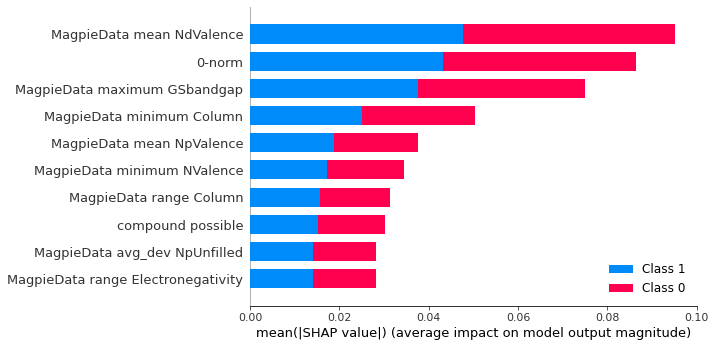

In [27]:
shap.summary_plot(shap_values, X_test_3, max_display = 10)

In [28]:
Output_shap_class1 = pd.DataFrame(shap_values[0], index = X_test_3.index, columns = X_test_3.columns)
Output_shap_class2 = pd.DataFrame(shap_values[1], index = X_test_3.index, columns = X_test_3.columns)

In [29]:
Output_shap_mean_class1 = pd.DataFrame(abs(Output_shap_class1).describe().loc['mean']/sum(abs(Output_shap_class1).describe().loc['mean'])).sort_values('mean', ascending = False)
Output_shap_mean_class2 = pd.DataFrame(abs(Output_shap_class2).describe().loc['mean']/sum(abs(Output_shap_class2).describe().loc['mean'])).sort_values('mean', ascending = False)

In [31]:
from matplotlib.pyplot import GridSpec
from matplotlib import gridspec

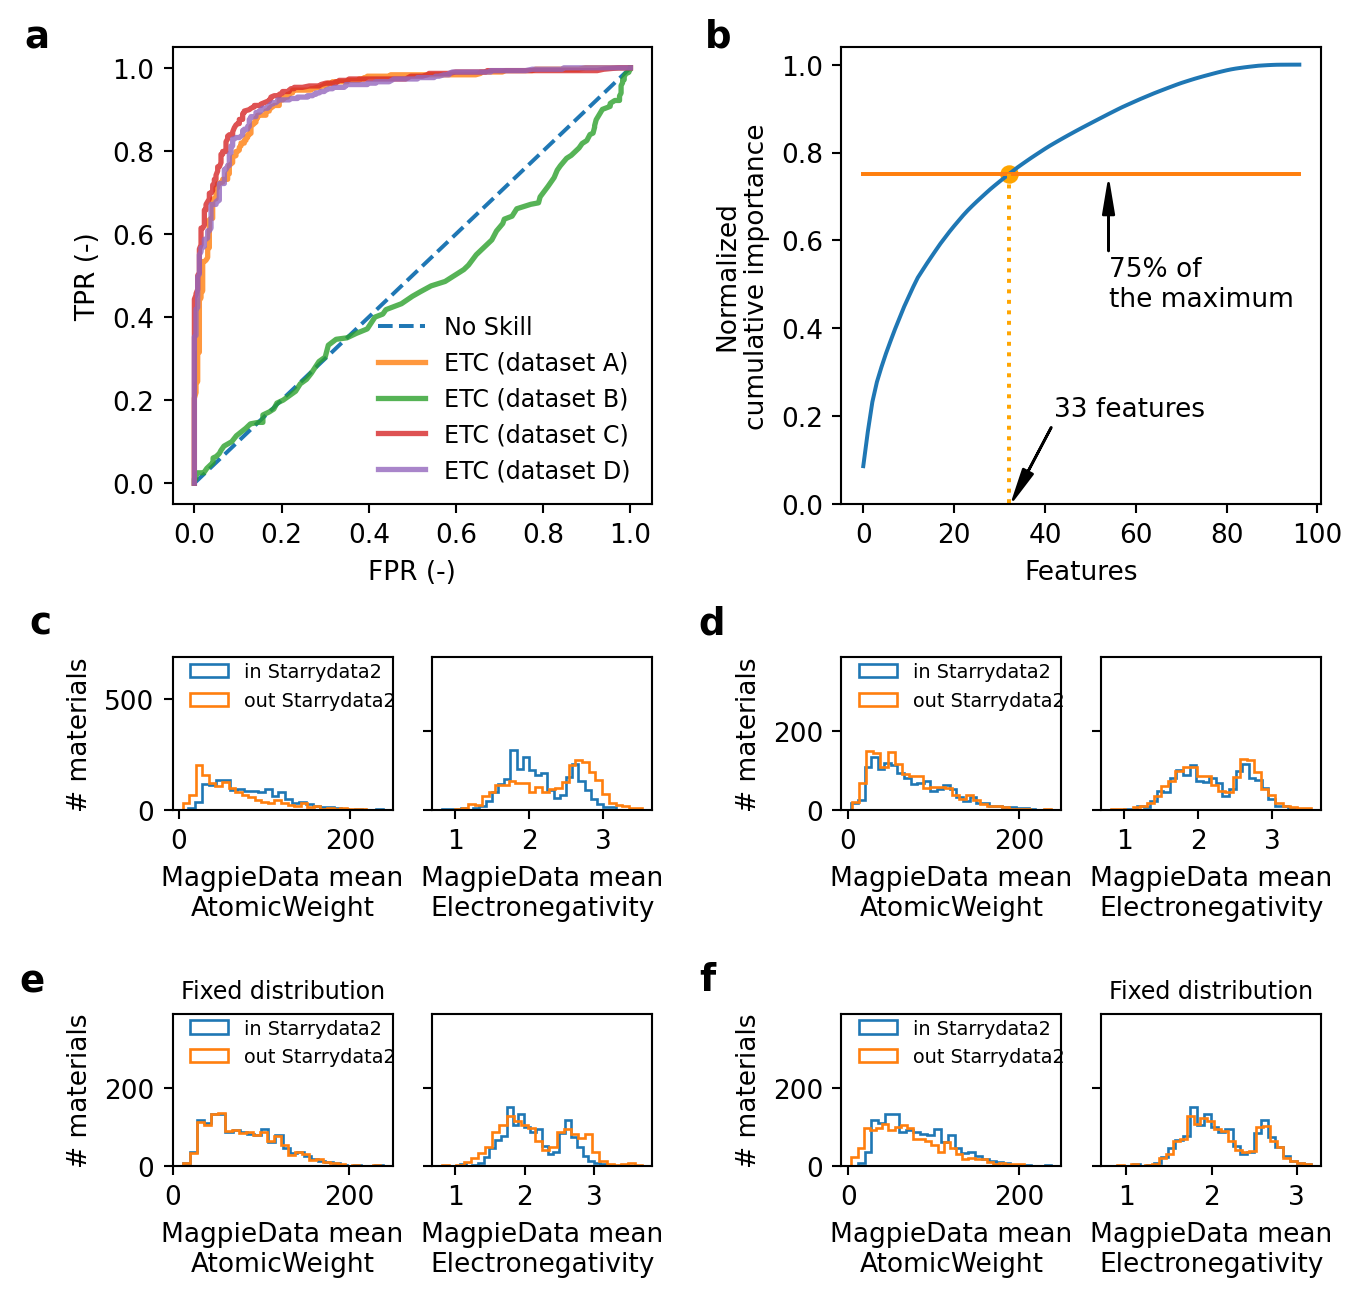

In [32]:
fig = plt.figure(1, figsize=(7.8, 7.8), dpi = 190)

gs = gridspec.GridSpec(5,5, width_ratios=[1,1,0.5,1,1], height_ratios=[.9, 0.15, 0.3, 0.25, 0.3])
#gridspec = dict(1, 5, width_ratios=[1, 1, .03, 1, 1])

ax5 = plt.subplot(gs[0, :2])
ax5.plot([0,1], [0,1], linestyle='--', label='No Skill')
alpha = .8
ax5.plot(fpr3, tpr3, linewidth = 2, label='ETC (dataset A)', alpha = alpha)
ax5.plot(fpr4, tpr4, linewidth = 2, label='ETC (dataset B)', alpha = alpha)
ax5.plot(fpr1, tpr1, linewidth = 2, label='ETC (dataset C)', alpha = alpha)
ax5.plot(fpr2, tpr2, linewidth = 2, label='ETC (dataset D)', alpha = alpha)
ax5.set_xlabel('FPR (-)')
ax5.set_ylabel('TPR (-)')
ax5.annotate(r'$\mathbf{a}$', xy = (0, 0), xytext = (-.39, 1.05), fontsize = 14)
ax5.legend(fontsize = 9, frameon = False)

ax6 = plt.subplot(gs[0, 3:5])
ax6.plot(np.arange(N), normalized_cumulative)
ax6.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k))
ax6.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax6.annotate('75% of\nthe maximum', xy=(54, 0.73), xytext=(54, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax6.scatter(ind_cross1, normalized_cumulative.iloc[ind_cross1], color = 'orange')
ax6.plot((ind_cross1, ind_cross1), (normalized_cumulative.iloc[ind_cross1], 0), color = 'orange', ls = ':')
ax6.set_ylim(0, 1.04)
ax6.set_xlabel('Features')
ax6.set_ylabel('Normalized\ncumulative importance')
ax6.annotate(r'$\mathbf{b}$', xy = (0, 0), xytext = (-35, 1.04), fontsize = 14)


ax7 = plt.subplot(gs[2, 0])
ax7.hist(df_3[df_3['is_in_starrydata'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in Starrydata2')
ax7.hist(df_3[df_3['is_in_starrydata'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out Starrydata2')
ax7.set_ylim(0, 690)
ax7.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax7.set_ylabel('# materials')
ax7.annotate(r'$\mathbf{c}$', xy = (0, 0), xytext = (-175, 800), fontsize = 14)
ax7.set_xlabel('MagpieData mean\nAtomicWeight')
ax8 = plt.subplot(gs[2, 1])
ax8.hist(df_3[df_3['is_in_starrydata'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax8.hist(df_3[df_3['is_in_starrydata'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax8.set_ylim(0, 390)
ax8.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax8.set_xlabel('MagpieData mean\nElectronegativity')


ax9 = plt.subplot(gs[2, 3])
ax9.hist(df_4[df_4['is_in_starrydata'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in Starrydata2')
ax9.hist(df_4[df_4['is_in_starrydata'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out Starrydata2')
ax9.set_ylim(0, 390)
ax9.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax9.set_ylabel('# materials')
ax9.annotate(r'$\mathbf{d}$', xy = (0, 0), xytext = (-175, 450), fontsize = 14)
ax9.set_xlabel('MagpieData mean\nAtomicWeight')
ax10 = plt.subplot(gs[2, 4])
ax10.hist(df_4[df_4['is_in_starrydata'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax10.hist(df_4[df_4['is_in_starrydata'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax10.set_ylim(0, 390)
ax10.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax10.set_xlabel('MagpieData mean\nElectronegativity')

ax1 = plt.subplot(gs[4, 0])
ax1.hist(df_1[df_1['is_in_starrydata'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in Starrydata2')
ax1.hist(df_1[df_1['is_in_starrydata'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out Starrydata2')
ax1.set_ylim(0, 390)
ax1.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax1.set_ylabel('# materials')
ax1.set_title('Fixed distribution', fontsize = 9)
ax1.annotate(r'$\mathbf{e}$', xy = (0, 0), xytext = (-175, 450), fontsize = 14)
ax1.set_xlabel('MagpieData mean\nAtomicWeight')
ax2 = plt.subplot(gs[4, 1])
ax2.hist(df_1[df_1['is_in_starrydata'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax2.hist(df_1[df_1['is_in_starrydata'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax2.set_ylim(0, 390)
ax2.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax2.set_xlabel('MagpieData mean\nElectronegativity')



ax3 = plt.subplot(gs[4, 3])
ax3.hist(df_2[df_2['is_in_starrydata'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in Starrydata2')
ax3.hist(df_2[df_2['is_in_starrydata'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out Starrydata2')
ax3.set_ylim(0, 390)
ax3.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax3.set_ylabel('# materials')
ax3.annotate(r'$\mathbf{f}$', xy = (0, 0), xytext = (-175, 450), fontsize = 14)
ax3.set_xlabel('MagpieData mean\nAtomicWeight')
ax4 = plt.subplot(gs[4, 4])
ax4.hist(df_2[df_2['is_in_starrydata'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax4.hist(df_2[df_2['is_in_starrydata'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax4.set_ylim(0, 390)
ax4.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax4.set_title('Fixed distribution', fontsize = 9)
ax4.set_xlabel('MagpieData mean\nElectronegativity')
plt.show()
